# 1.1 Camera Caliberation 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os 
%matplotlib inline
switch = True 
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/camera_cal/')
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
        if switch == True:
            cv2.imwrite('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/projectImages/camera.jpg',img.astype('float'))
            switch = False
#         cv2.waitKey(500)

cv2.destroyAllWindows()

# 1.2 Correcting Distortion

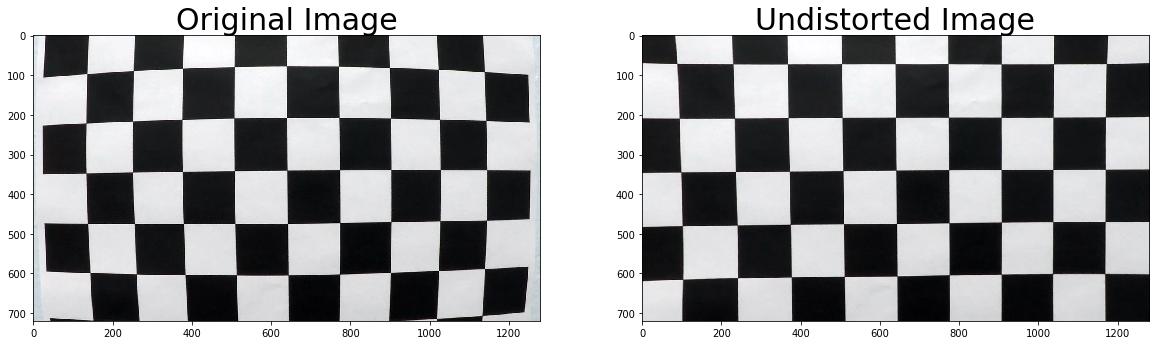

In [2]:
import pickle
import os
%matplotlib inline

# Test undistortion on an image
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/camera_cal')
img = cv2.imread('calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/projectImages'
# plt.show()
# fig.savefig(loc+'/undistorted.jpg')  
# plt.close(fig)

# 2 Perspective Transformation

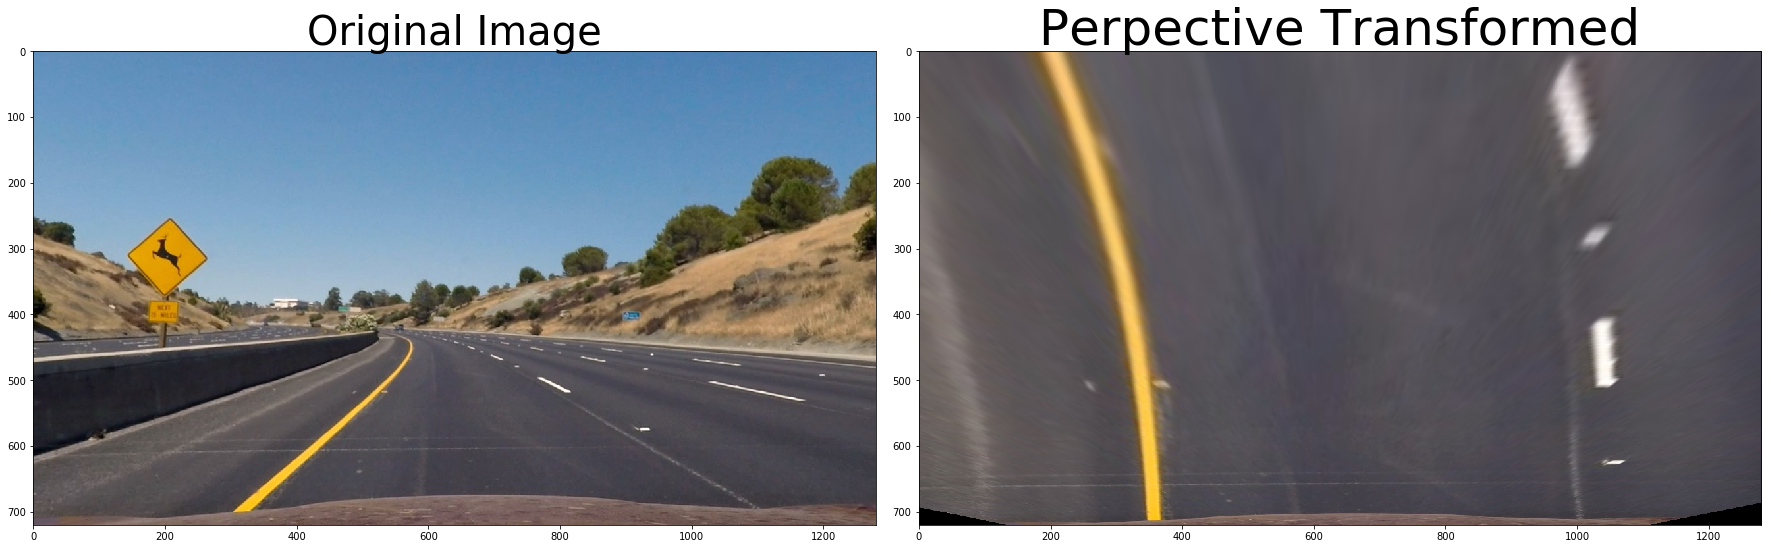

In [13]:
%matplotlib inline

loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/test_images'
os.chdir(loc)
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = cv2.imread('test2.jpg')
# undistort image 
img = cv2.undistort(img, mtx, dist, None, mtx)
offset = 290
# in the cv2 transformation first dimension is x second is y 
# in image.shape first dimension is y then x
img_size = (img.shape[1],img.shape[0])
src = np.float32([[585,460],
                  [203,720],
                  [1127,720],
                  [695,460]])
dst = np.float32([[offset,0],
                  [offset,img_size[1]],
                  [img_size[0]-offset,img_size[1]],
                  [img_size[0]-offset,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
ax2.set_title('Perpective Transformed', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/projectImages'
plt.show()
fig.savefig(loc+'/perspective2.jpg')  
plt.close(fig)

# 3 Binary Image Generation

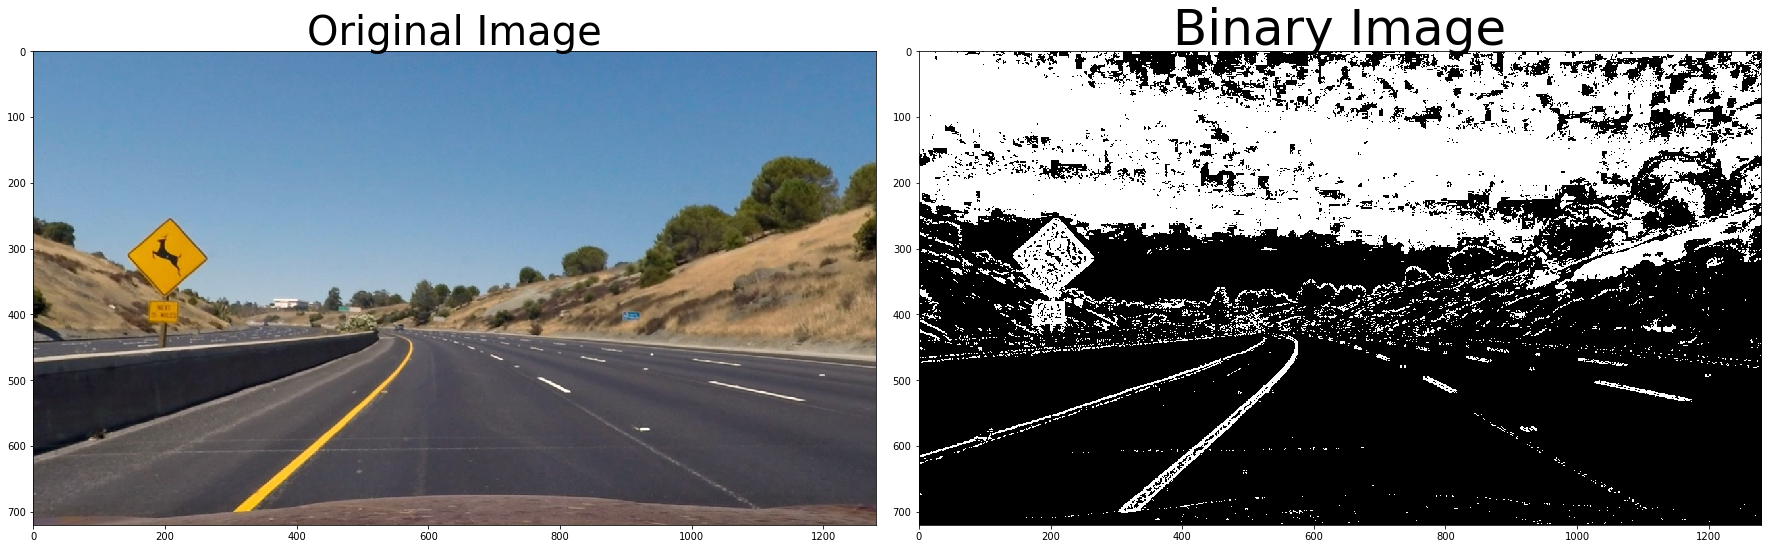

In [14]:
def mag_thresh(img, mag_thresh=(0, 255), sobel_kernel=3):
    '''
    this function take as input a color image and outputs a binary (0,1) image
    based on whether each gray image pixel has a gradient magnitude that falls 
    between mag_thresh value
    '''
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)    
    # Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel =  np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) & (scaled_sobel <mag_thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(img, orient='x', mag_thresh=(0, 255), sobel_kernel=3):
    '''
    this function take as input a color image and outputs a binary (0,1) image
    based on whether each gray image pixel has a gradient magnitude in direction
    specified with the orient that falls between mag_thresh value
    '''    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    '''
    a color image is turned into a bindary image based on a threshold on it HLS transform's S layer
    '''
    #  HLS space (hue (0-179), lightness, and saturation (0-255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0]) & (s<thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(0, 255)):
    '''
    a color image is turned into a bindary image based on a threshold on it HSV transform's V layer
    '''
    #  HSV space (hue (0-179), saturation, and value)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v = hsv[:,:,2]
    binary_output = np.zeros_like(v)
    binary_output[(v>=thresh[0]) & (v<=thresh[1])] = 1
    return binary_output

def masking_pipeline(img):
    '''
    combines various filtering criteria including color spaces and gradients for the final binary output
    '''
    img = np.copy(img)
    c_hls = hls_select(img, thresh=(100, 255))
    c_hsv = hsv_select(img, thresh=(50, 255))
    gradx = abs_sobel_thresh(img, orient='x', mag_thresh=(12, 255), sobel_kernel=3)
    grady = abs_sobel_thresh(img, orient='y', mag_thresh=(25, 255), sobel_kernel=3)
    combined = np.zeros_like(img[:,:,1])
    
    combined[((gradx == 1) & (grady  == 1)) | ((c_hls  == 1) &  (c_hsv  == 1))] = 1
    return combined


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(masking_pipeline(img), cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()


plt.show()
fig.savefig(loc+'/binary1.jpg')  
plt.close(fig)

# 4 Final PipeLine

In [6]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/projectImages'
polySmoothingLeft = np.empty([1, 3])
polySmoothingRight = np.empty([1, 3])
globalCounter = 0



def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def outlier_removal(polySmoothingLeft,polySmoothingRight,left_fit,right_fit):
    '''
    function below uses the average of polynomial fits from previous images 
    to draw final polynomial on a given image. to pass parameters from previous frames 
    to the current frame we use i used a global variable
    
    the function also has a capability of rejecting polynomial fits that are very different form 
    previous frames fits. However the removing outliers did not improve performance. 
    '''

    if polySmoothingLeft.shape[0] > 5:
        left_fitB_mean = polySmoothingLeft[-5:,:].mean(axis =0)
        left_fitB_std = polySmoothingLeft[-5:,:].std(axis =0)
        left_fitB_uci = left_fitB_mean + 100*left_fitB_std
        left_fitB_lci = left_fitB_mean - 100*left_fitB_std
        if (left_fit <= left_fitB_uci).all() & (left_fit >= left_fitB_lci).all():
            polySmoothingLeft = np.append(polySmoothingLeft,[[left_fit[0],left_fit[1],left_fit[2]]], axis = 0)
        left_fitB = polySmoothingLeft[-15:,:].mean(axis =0)
        polySmoothingLeft = polySmoothingLeft[-15:,:]
    else:
        # if you do not have that many points for smoothing do not throw any of them out 
        polySmoothingLeft = np.append(polySmoothingLeft,[[left_fit[0],left_fit[1],left_fit[2]]], axis = 0)
        left_fitB = polySmoothingLeft[1:5,:].mean(axis =0)
        
        
    if polySmoothingLeft.shape[0] > 5:    
        right_fitB_mean = polySmoothingRight[-5:,:].mean(axis =0)
        right_fitB_std = polySmoothingRight[-5:,:].std(axis =0)
        right_fitB_uci = right_fitB_mean + 10*right_fitB_std
        right_fitB_lci = right_fitB_mean - 10*right_fitB_std
        if (right_fit <= right_fitB_uci).all() & (right_fit >= right_fitB_lci).all():
            polySmoothingRight = np.append(polySmoothingRight,[[right_fit[0],right_fit[1],right_fit[2]]], axis = 0)    
        right_fitB = polySmoothingRight[-15:,:].mean(axis =0)
        polySmoothingRight = polySmoothingRight[-15:,:]
    else:
        polySmoothingRight = np.append(polySmoothingRight,[[right_fit[0],right_fit[1],right_fit[2]]], axis = 0)    
        right_fitB = polySmoothingRight[1:5,:].mean(axis =0)         
        
    return polySmoothingLeft,polySmoothingRight,left_fitB,right_fitB
    


def lineFiner(binary_warped,Minv,img_size,undistorted):
    global polySmoothingLeft 
    global polySmoothingRight
    global globalCounter
    # for drawing 
#     histogram = np.sum(binary_warped, axis=0)
#     fig, ax = plt.subplots(1)
#     ax.plot(histogram)
#     fig.savefig(loc+'/hist1.jpg')  
#     plt.close(fig)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # there will be two pixel values 0 and 255 
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # looking at the two peaks form the histogram 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    # y coordinates of non-zero pixels
    nonzeroy = np.array(nonzero[0])
    # x coordinates of non-zero pixels
    nonzerox = np.array(nonzero[1])
    # Current positions of ?(line?) to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows of ?! +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # go through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # we are defining a rectangular area 
        # from the center of the lane to left and right of it  
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5)
        # Identify the nonzero pixels in x and y within the window
        # retuns the indexes of points inside each rectangle 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        # otherwise the last center point we have is used 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # notice that we are fitting f(y) = x 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # smoothing function is called below to output smoothed polynomial fits  
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    polySmoothingLeft,polySmoothingRight,left_fitB,right_fitB = outlier_removal(polySmoothingLeft,
                                 polySmoothingRight,
                                 left_fit,
                                 right_fit)
    # we feed the y's and the polynomial gives us the corresponding x's
    left_fitx = left_fitB[0]*ploty**2 + left_fitB[1]*ploty + left_fitB[2]
    right_fitx = right_fitB[0]*ploty**2 + right_fitB[1]*ploty + right_fitB[2]

    # color coding the point clouds that are used to draw the line in the output image
    # the points that are on the left get [255,0,0] and all non zero points on right [0,0,255]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # for plotting bounding windows 
    # cv2.imwrite(loc + '/boundingWindows2.jpg',out_img.astype('float'))    
    # plotting the polynomials into the perspective image 
    polyimage = np.zeros_like(out_img)
#     fig, ax = plt.subplots(1)
#     ax.imshow(out_img)
#     ax.plot(left_fitx, ploty, color='yellow')
#     ax.plot(right_fitx, ploty, color='yellow')
#     fig.savefig(loc+'/poly1.jpg')  
#     plt.close(fig)
    
    # we create two copies of the out_img mainly because of better representation of
    # lines in cv2. please see the fillpolly below 
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    window_img_bkg = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    

    
    margin = 20
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    # left_fitx points from the polygon 
    # points are [x - margin , y] , and [x + margin, y] across y (ploty) and x values comes from the polynomial
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    center_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    center_line_pts = np.hstack((center_line_window1, center_line_window2))

    
    # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
#     cv2.fillPoly(window_img_bkg, np.int_([left_line_pts]), (255,255, 255))
#     cv2.fillPoly(window_img_bkg, np.int_([right_line_pts]), (255,255, 255))
    cv2.fillPoly(window_img_bkg, np.int_([center_line_pts]), (255,25, 0))

    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicleDeviation = abs(midpoint - (rightx_base + leftx_base)/2.0)*xm_per_pix
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # adding the lane line fits to the original image
    window_img = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    window_img_bkg = cv2.warpPerspective(window_img_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
    base = cv2.addWeighted(undistorted,1.0,window_img_bkg,-1.0,0.0)
    outputImage = cv2.addWeighted(base,1,window_img,1,0.0)
    
    # adding curvature and off-center lengths on the images 
    cv2.putText(outputImage,
        'Radius of Curvature = ' +
                str(round((left_curverad+right_curverad)*0.5,3)) + '(m)',(50,50),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255) ,2)
    cv2.putText(outputImage,
        'Vehicle is off center by ' +
                str(round(vehicleDeviation,3)) + '(m)',(50,100),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255) ,2)    

    return outputImage,left_curverad,right_curverad

def pipeline(img):
    # for image uncomment line below
#     img = cv2.imread('test1.jpg')
    img_size = (img.shape[1],img.shape[0])
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped = masking_pipeline(warped)
    out_img,_,_ = lineFiner(binary_warped,Minv,img_size,undistorted)
    return out_img


# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# for video uncomment this:
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/')
white_output = 'submission_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# for image uncomment this 
# os.chdir('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/test_images/')
# img = cv2.imread('test1.jpg')
# outputImage = pipeline(img)
# plt.imshow(cv2.cvtColor(outputImage, cv2.COLOR_BGR2RGB))
# cv2.imwrite(loc+'/final1.jpg',outputImage)

[MoviePy] >>>> Building video submission_video.mp4
[MoviePy] Writing video submission_video.mp4


100%|█████████▉| 1260/1261 [02:31<00:00,  8.86it/s]    | 1/1261 [00:00<03:19,  6.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission_video.mp4 

CPU times: user 13min 10s, sys: 4.26 s, total: 13min 14s
Wall time: 2min 31s
